# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from itertools import accumulate

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [14]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2  # how dense are the sets (low density means each set has few elements)

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [15]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [16]:
# def valid(solution):
def valid(solution, sets):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(sets[solution]))


def cost(solution, costs):
    """Returns the cost of a solution (to be minimized)"""
    return costs[solution].sum()

## Have Fun!

#### Tweak function

```single_mutation ``` function is used to mutate a single set in the solution. It takes the solution and the set to be mutated as input and returns the mutated solution.

```multiple_mutation``` function is used to mutate multiple sets in the solution. It takes the solution and the number of sets to be mutated as input and returns the mutated solution.

```multiple_mutation_strength``` function is used to mutate multiple sets in the solution. It takes the solution and the number of sets to be mutated as input and returns the mutated solution. The number of sets to be mutated is calculated based on the strength parameter. The strength parameter is used to calculate the number of sets to be mutated.


This last tweak is used in the hill climbing algorithm to mutate the solution.


In [17]:
def single_mutation(solution, NUM_SETS, rng):
    new_solution = solution.copy()
    random_set = rng.integers(0, NUM_SETS)
    new_solution[random_set] = not new_solution[random_set]
    return new_solution

def multiple_mutation(solution, NUM_SETS, rng):
    mask = rng.random(NUM_SETS) < 0.01 # 1% chance of mutation
    new_solution = np.logical_xor(solution, mask)
    return new_solution


def multiple_mutation_strength(solution, NUM_SETS, strength: float = 0.3):
    mask = np.random.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    return np.logical_xor(solution, mask)

tweak = multiple_mutation_strength

#### Fitness function
Defined as the validation of the cover and the number of sets in the cover 

In [18]:
def fitness(solution, sets, costs): # fitness is something to be maximized, minimizing cost instead
    return (valid(solution,sets),-cost(solution, costs) )

#### Hill Climbing

The algorithm is initialized with a random solution. The algorithm then iterates over the solution and mutates the solution using the tweak function. The fitness of the mutated solution is calculated and compared with the fitness of the current solution. If the fitness of the mutated solution is better than the current solution, the current solution is updated with the mutated solution. The algorithm continues to iterate until the fitness of the solution does not improve.
The strength parameter is decreased as iterations progress.

In [19]:
def hill_climber(solution, SETS, COSTS, NUM_SETS, max_steps, strength = 0.5):
    history = [fitness(solution, SETS, COSTS)]
    num_calls = 0

    for step in tqdm(range(max_steps)):
        if step % 1000:
            strength /= 2

        new_solution = tweak(solution, NUM_SETS, strength)
        f = fitness(new_solution, SETS, COSTS)
        if f > fitness(solution, SETS, COSTS):
            num_calls += 1
            solution = new_solution
        
        history.append(f)

    return solution, history, num_calls

#### Simulated Annealing

This algorithm starts with an initial (random) solution and an initial temperature. In each iteration, the algorithm generates a new solution by applying a tweak to the current solution. The fitness of the new solution is then evaluated.

If the new solution has a better fitness, it is accepted as the current solution. If the new solution is worse, it may still be accepted based on a probabilistic criterion that depends on the temperature and the fitness difference. This mechanism allows the algorithm to escape local optima.

As the algorithm progresses, the temperature decrease, gradually transitioning from exploration to exploitation. The process continues until the maximum number of iterations is reached or the temperature cools to zero. 

In [20]:
def simulated_annealing(solution, SETS, COSTS, NUM_SETS, max_steps, initial_temp, cooling_rate, strength = 0.5):
    current_solution = solution.copy()
    current_fitness = fitness(current_solution, SETS, COSTS)
    best_solution = current_solution
    best_fitness = current_fitness
    temp = initial_temp

    history = [current_fitness]

    num_calls = 0

    for step in tqdm(range(max_steps)):
        if temp <= 0:
            break

        if step % 1000:
            strength /= 2

        new_solution = tweak(current_solution, NUM_SETS, strength=0.5)
        
        new_fitness = fitness(new_solution, SETS, COSTS)
        
        if new_fitness > current_fitness:
            num_calls += 1
            current_solution = new_solution
            current_fitness = new_fitness
        else:
            delta = new_fitness[1] - current_fitness[1]
            if np.random.rand() < np.exp(delta / temp):
                current_solution = new_solution
                current_fitness = new_fitness

        temp *= cooling_rate
        history.append(new_fitness)

        if current_fitness > best_fitness:
            best_solution = current_solution
            best_fitness = current_fitness

    return best_solution, history, num_calls


#### Tabu Search
Starting from an initial (random) solution, it iteratively explores the neighborhood by generating multiple candidate solutions (neighbors) through a tweak function. Each neighbor is evaluated based on its fitness, which is determined by the total cost of the sets.

To avoid revisiting previously explored solutions, a tabu list is maintained. Each move that modifies the solution is stored in the tabu list with a certain tenure (a number of steps during which the move is considered forbidden). However, a tabu move can still be accepted if the corresponding solution improves the overall best fitness found so far.

At each iteration, the algorithm selects the best non-tabu neighbor and updates the current solution. If the new solution is better than the best one found so far, it updates the best solution. The algorithm also includes early stopping if no improvement is made for a specified number of iterations (patience parameter).

The process continues until a maximum number of steps is reached or the patience limit is exceeded. 

In [21]:
def tabu_search(initial_solution, SETS, COSTS, NUM_SETS, max_steps, tabu_tenure, max_tabu_size, rng, tweak, neighbor_sample_size=10, patience=50):  
    """Simplified Tabu Search implementation for Set Cover"""
    current_solution = initial_solution.copy()
    current_fitness = fitness(current_solution, SETS, COSTS)
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    
    tabu_dict = {}
    history = [current_fitness]
    no_improvement_steps = 0
    num_calls = 0
    for step in tqdm(range(max_steps)):
        best_neighbor = None
        best_neighbor_fitness = None
        best_move_index = None
        
        # Generate and evaluate neighbors
        for _ in range(neighbor_sample_size):
            neighbor = tweak(current_solution, NUM_SETS, rng)
            changed_indices = np.where(neighbor != current_solution)[0]
            
            if len(changed_indices) == 0:
                continue
                
            move_index = int(changed_indices[0])
            neighbor_fitness = fitness(neighbor, SETS, COSTS)
            
            # Skip if tabu and not better than best known
            if move_index in tabu_dict and step < tabu_dict[move_index] and neighbor_fitness <= best_fitness:
                continue
                
            # Update best neighbor if better
            if best_neighbor is None or neighbor_fitness > best_neighbor_fitness:
                num_calls += 1
                best_neighbor = neighbor
                best_neighbor_fitness = neighbor_fitness
                best_move_index = move_index
        
        # If no valid neighbor found, terminate
        if best_neighbor is None:
            break
            
        # Update current solution and tabu list
        current_solution = best_neighbor
        current_fitness = best_neighbor_fitness
        tabu_dict[best_move_index] = step + tabu_tenure
        
        # Update best solution if improved
        if current_fitness > best_fitness:
            best_solution = current_solution.copy()
            best_fitness = current_fitness
            no_improvement_steps = 0
        else:
            no_improvement_steps += 1
            
        # Early stopping
        if no_improvement_steps > patience:
            break
            
        history.append(current_fitness)
    
    return best_solution, history, num_calls

```generate_sets``` helper function to generate the sets given universe size, number of sets and density
```plot_result``` helper function to plot the results
```run_experiments``` runs algorithms given the instances and plots the results

In [ ]:
# Function to generate dataset
def generate_sets(universe_size, num_sets, density):
    # Generate subsets and costs
    SETS = np.random.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(num_sets), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    return SETS, COSTS

# Function to plot the results
def plot_results(cost_values, label, color):
    plt.plot(range(len(cost_values)), list(accumulate(cost_values, max)), label=label, color=color)
    _ = plt.scatter(range(len(cost_values)), cost_values, marker=".", label="Cost per iteration", color=color)

# Function to run tests for each parameter combination
def run_experiments(instances):


    
    max_steps = 1000

    # Parameters for Simulated Annealing
    initial_temp = 1000
    cooling_rate = 0.995

    # Run algorithms for each instance
    for instance in instances:
        universe_size = instance["Universe size"]
        num_sets = instance["Num sets"]
        density = instance["Density"]
        print(f"\n--- Running for Universe size={universe_size}, Num sets={num_sets}, Density={density} ---")
        rng = np.random.Generator(np.random.PCG64([universe_size, num_sets, int(10_000 * density)]))
        # Generate the dataset
        SETS, COSTS = generate_sets(universe_size, num_sets, density)
        solution = rng.random(num_sets) < 1
        # Execute the algorithms
        print("Running Hill Climber...")
        hc_solution, hc_history, hc_n_iterations = hill_climber(solution, SETS, COSTS, num_sets, max_steps)
        print("Running Simulated Annealing...")
        sa_solution, sa_history, sa_n_iterations = simulated_annealing(solution, SETS, COSTS, num_sets, max_steps, initial_temp, cooling_rate)
        print("Running Tabu Search...")
        ts_solution, ts_history, ts_n_iterations = tabu_search(solution, SETS, COSTS, num_sets, max_steps, 5, 10, rng, tweak=single_mutation, neighbor_sample_size=100, patience=200)

        # Print the best solutions
        print(f"Hill Climber best solution cost: {-cost(hc_solution, COSTS)} in {hc_n_iterations} calls")
        print(f"Simulated Annealing best solution cost: {-cost(sa_solution, COSTS)} in {sa_n_iterations} calls")
        print(f"Tabu Search best solution cost: {-cost(ts_solution, COSTS)} in {ts_n_iterations} calls")

        # Plot the results
        plt.figure(figsize=(12, 6))
        cost_values = [c for _, c in hc_history]
        plot_results(cost_values, "Hill climbing", "red")
        cost_values = [c for _, c in sa_history]
        plot_results(cost_values, "Simulated Annealing", "blue")
        cost_values = [c for _, c in ts_history]
        plot_results(cost_values, "Tabu Search", "green")

        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.legend()
        plt.title(f"Cost Reduction for Universe size={universe_size}, Num sets={num_sets}, Density={density}")
        plt.grid(True)
        plt.show()


instances = [
    {"Universe size": 100, "Num sets": 10, "Density": 0.2},
    {"Universe size": 1_000, "Num sets": 100, "Density": 0.2},
    {"Universe size": 10_000, "Num sets": 1_000, "Density": 0.2},
    {"Universe size": 100_000, "Num sets": 10_000, "Density": 0.1},
]

# Run the comparison between algorithms for all combinations
run_experiments(instances)


Results show that Tabu search performs better than the other algorithms but requires more time to converge (~140x more time than HC, ~350x more calls to the fitness function than SA and 16x more calls than RMCH). SA is the fastest algorithm but does not perform as well as Tabu search or HC. 
So HC seems to be the best trade-off between performance and time.


--- Running for Universe size=100, Num sets=10, Density=0.2 ---
Running Hill Climber...


  0%|          | 0/1000 [00:00<?, ?it/s]

Hill Climber best solution cost: -292.9252455258281 in 0 calls


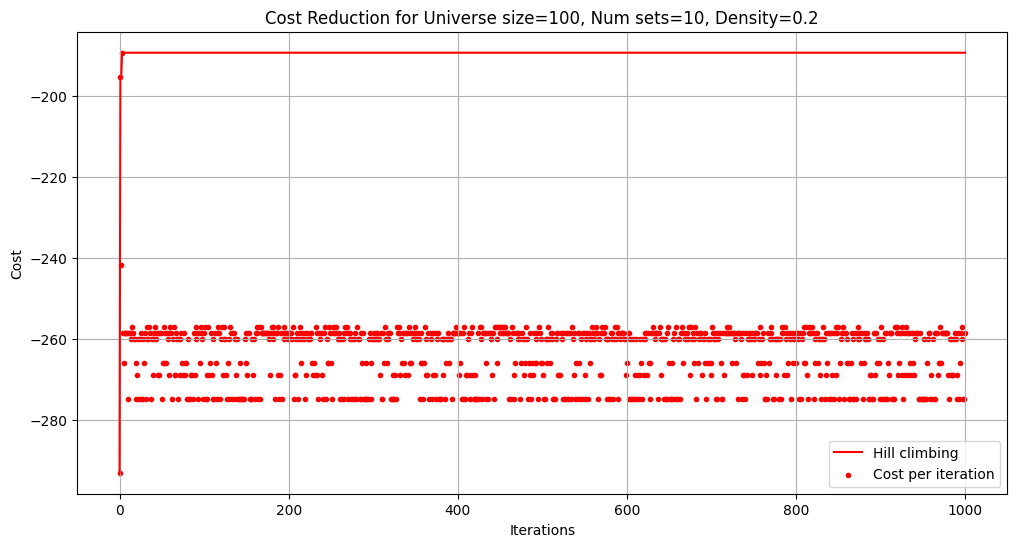


--- Running for Universe size=1000, Num sets=100, Density=0.2 ---
Running Hill Climber...


  0%|          | 0/1000 [00:00<?, ?it/s]

Hill Climber best solution cost: -7689.435745664797 in 19 calls


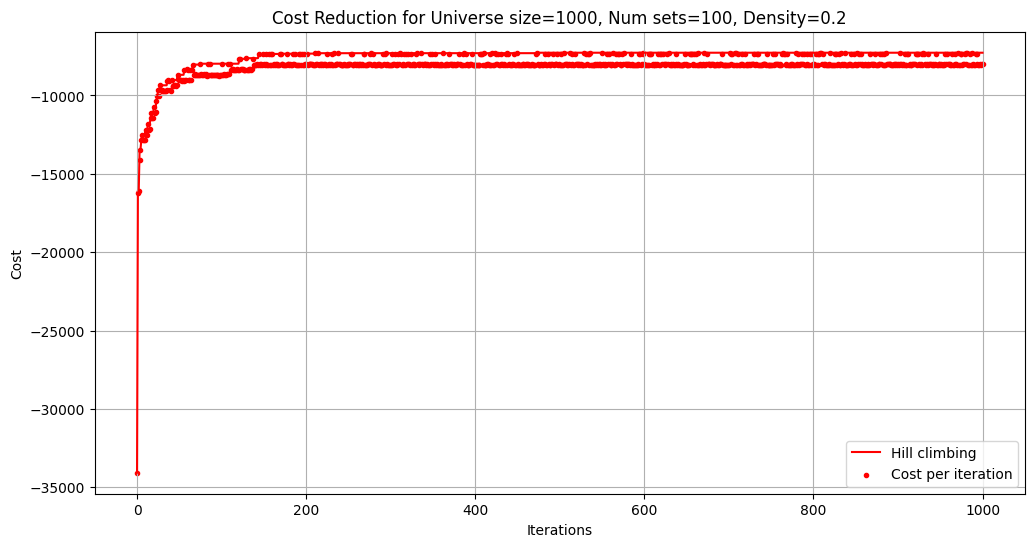


--- Running for Universe size=10000, Num sets=1000, Density=0.2 ---
Running Hill Climber...


  0%|          | 0/1000 [00:00<?, ?it/s]

Hill Climber best solution cost: -741479.2806843796 in 292 calls


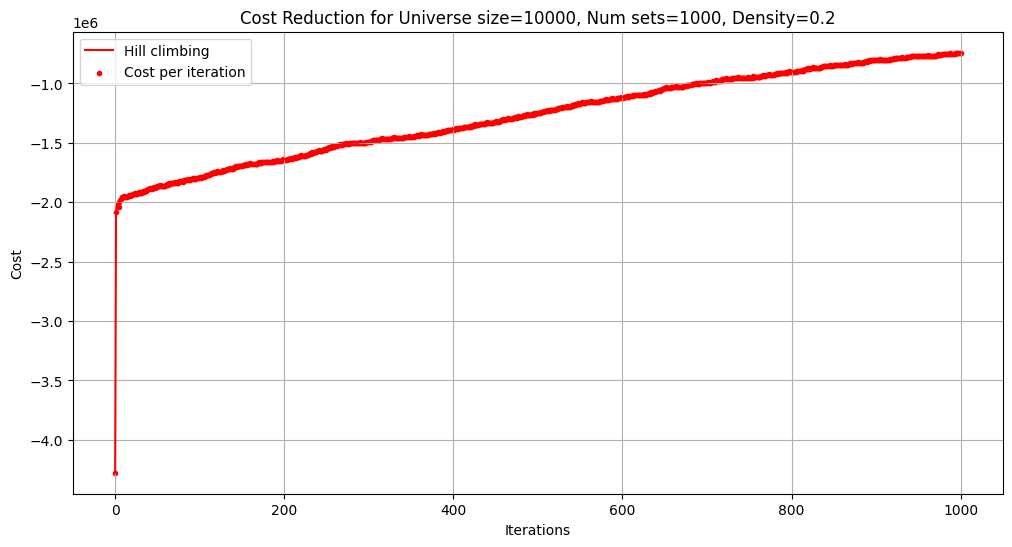


--- Running for Universe size=100000, Num sets=10000, Density=0.1 ---
Running Hill Climber...


  0%|          | 0/1000 [00:00<?, ?it/s]

Hill Climber best solution cost: -112751635.59219617 in 435 calls


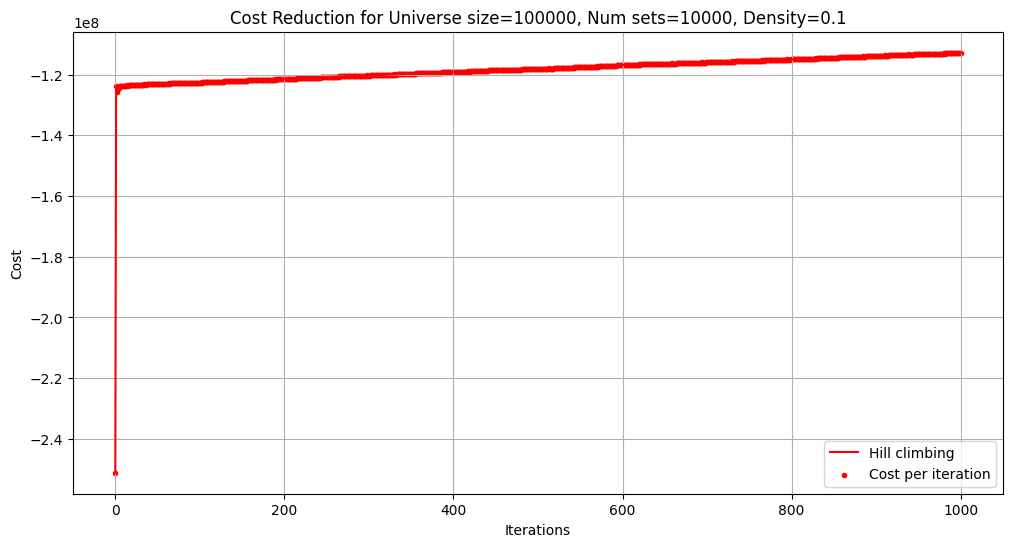


--- Running for Universe size=100000, Num sets=10000, Density=0.2 ---
Running Hill Climber...


  0%|          | 0/1000 [00:00<?, ?it/s]

Hill Climber best solution cost: -238795309.17751583 in 489 calls


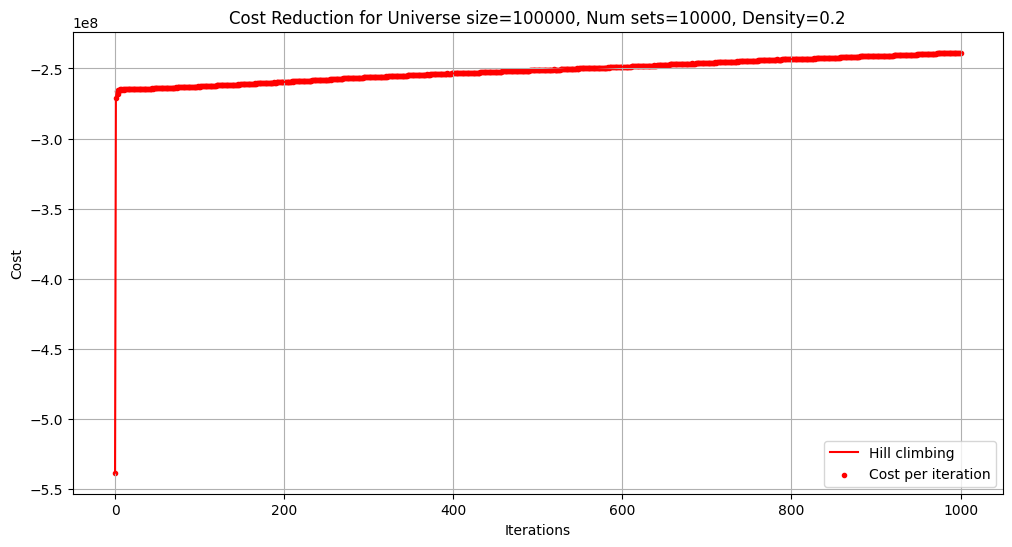


--- Running for Universe size=100000, Num sets=10000, Density=0.3 ---
Running Hill Climber...


  0%|          | 0/1000 [00:00<?, ?it/s]

Hill Climber best solution cost: -370743077.1175643 in 474 calls


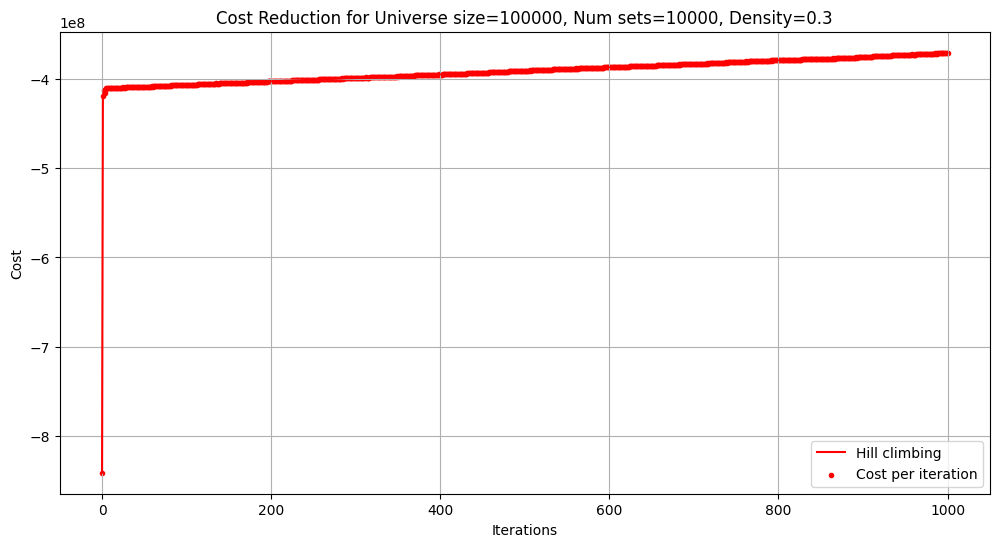

In [22]:
max_steps = 1000

instances = [
    {"Universe size": 100, "Num sets": 10, "Density": 0.2},
    {"Universe size": 1_000, "Num sets": 100, "Density": 0.2},
    {"Universe size": 10_000, "Num sets": 1_000, "Density": 0.2},
    {"Universe size": 100_000, "Num sets": 10_000, "Density": 0.1},
    {"Universe size": 100_000, "Num sets": 10_000, "Density": 0.2},
    {"Universe size": 100_000, "Num sets": 10_000, "Density": 0.3}
]

# Run algorithms for each instance
for instance in instances:
    universe_size = instance["Universe size"]
    num_sets = instance["Num sets"]
    density = instance["Density"]
    print(f"\n--- Running for Universe size={universe_size}, Num sets={num_sets}, Density={density} ---")
    rng = np.random.Generator(np.random.PCG64([universe_size, num_sets, int(10_000 * density)]))
    # Generate the dataset
    SETS, COSTS = generate_sets(universe_size, num_sets, density)
    solution = rng.random(num_sets) < 1
    # Execute the algorithms
    print("Running Hill Climber...")
    hc_solution, hc_history, hc_n_iterations = hill_climber(solution, SETS, COSTS, num_sets, max_steps)
    
    # Print the best solutions
    print(f"Hill Climber best solution cost: {-cost(hc_solution, COSTS)} in {hc_n_iterations} calls")
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    cost_values = [c for _, c in hc_history]
    plot_results(cost_values, "Hill climbing", "red")

    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.legend()
    plt.title(f"Cost Reduction for Universe size={universe_size}, Num sets={num_sets}, Density={density}")
    plt.grid(True)
    plt.show()
